# ME/CS/EE 133b Set #1
### Kevin Gauld

## Problem 1: Discrete Planning Challenge

### Setup

Here, we import required modules and define some helpful constants

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Define the possible status levels for each state.
WALL      = 0
UNKNOWN   = 1
ONDECK    = 2
PROCESSED = 3
PATH      = 4

# Define the constant START and GOAL positions
START = (5,  4)
GOAL  = (5, 12)

### Helper Functions


#### showgrid(M,N)

Create a figure for an M (rows) x N (column) grid.  The X-axis will be the columns (to the right) and the Y-axis will be the rows (top downward). The only change between this function and the one posted on Canvas is the addition of an extra color to show the path in the final view of the grid.

In [3]:
def showgrid(state):

    # Grab the dimensions.
    M = np.size(state, axis=0)
    N = np.size(state, axis=1)

    # Close the old figure.
    plt.close()

    # Create the figure and axes.
    fig = plt.figure()
    ax  = plt.axes()

    # turn off the axis labels
    ax.axis('off')

    # Draw the grid, zorder 1 means draw after zorder 0 elements.
    for m in range(M+1):
        ax.axhline(m, lw=1, color='b', zorder=1)
    for n in range(N+1):
        ax.axvline(n, lw=1, color='b', zorder=1)

    # Create the color range.  There are clearly more elegant ways...
    color = np.ones((M,N,3))
    for m in range(M):
        for n in range(N):
            if   state[m,n] == WALL:
                color[m,n,0:3] = np.array([0.0, 0.0, 0.0])   # Black
            elif state[m,n] == UNKNOWN:
                color[m,n,0:3] = np.array([1.0, 1.0, 1.0])   # White
            elif state[m,n] == ONDECK:
                color[m,n,0:3] = np.array([0.0, 1.0, 0.0])   # Green
            elif state[m,n] == PROCESSED:
                color[m,n,0:3] = np.array([0.0, 0.0, 1.0])   # Blue
            elif state[m,n] == PATH:
                color[m,n,0:3] = np.array([0.2, 1.0, 1.0])   # Cyan
            else:
                color[m,n,0:3] = np.array([1.0, 0.0, 0.0])   # Red
    
    # Draw the boxes
    ax.imshow(color, aspect='equal', interpolation='none',
              extent=[0, N, 0, M], zorder=0)

    # Force the figure to pop up.
    plt.pause(0.001)

#### resetState()

Returns a new state with the walls and unknowns as defined in the problem statement. This is largely adapted from the demo code, but has been reimplemented as a function.

In [4]:
def resetState():
    # Define the grid with unknown states.
    M = 11
    N = 17
    
    state = np.ones((M,N)) * UNKNOWN
    
    # Populate the states
    state[ 0,0:] = WALL
    state[-1,0:] = WALL
    state[0:, 0] = WALL
    state[0:,-1] = WALL
    
    state[3, 4:10] = WALL
    state[4,   10] = WALL
    state[5,   11] = WALL
    state[6,   12] = WALL
    state[7,   13] = WALL
    state[7:M,  7] = WALL
    
    return state

#### build_path(goal, pnodes)

Given a goal and a dictionary mapping a node to the one before it, returns an ordered list from the start node to the final node. This function is used to reconstruct the paths once the searches complete. This function assumes there is a backwards path from the final node to some 'start' node which corresponds to `None` in the dictionary of previous nodes (has no prior node).

In [5]:
def build_path(goal, pnodes):
    # Start the path at the end
    path = [goal]
    current = goal
    
    # While the current node has one before it, add the prior
    # node to the path then redo the check with this node
    while pnodes[current] != None:
        path.append(pnodes[current])
        current = pnodes[current]
    
    # Once the start node is reached, reverse the path (start -> goal) and return
    path.reverse()
    return path

### a) Djikstra

The following function takes the start and goal positions along with the state of the board and goes through the Djikstra algorithm. The function returns a tuple where the first index holds the computed path from the start to the goal and the second index holds the final state of the board.

The algorithm works as follows:
1. A FIFO Queue (ondeck) is created to hold ondeck nodes, and a dictionary (prior_node) is created to map a node to its prior node. The Queue is initialized holding only the start node, and the dictionary starts only mapping the start node to `None` (since start does not have a prior node)
2. While ondeck contains nodes:
    * Pop the next node in ondeck, and call it the 'current' node.
    * If the current node is the goal, mark it as processed and return the path and state.
    * For each node which can be reached from the current node, if its state is unknown, mark it as ondeck by adding it to the list and marking its state, then assign its prior node to the current node.
    * Once all child nodes have been checked, mark the current node as processed.
3. When ondeck is empty, this means a path could not be found, so return None for the path and the final state.

In [6]:
def djikstra(start, goal, state):
    # Tracks which nodes are in ondeck and when they were added to ondeck
    ondeck = [start]
    # For any node, stores the node prior to it
    prior_node = {start:None}
    
    # While there is a node that has not been fully processed, process it
    while ondeck:
        
        # Get whatever has been in ondeck the longest (first element)
        current = ondeck.pop(0)
        if current == goal:
            state[current] = PROCESSED
            # Return the path used to get to the goal and the state
            return (build_path(goal, prior_node), state)
        
        # Get the next nodes in each direction (up down left right)
        for i in (-1,1): # -1 for up/left, +1 for down/right
            for axis in (0, 1): # axis 0 for right/left, 1 for up/down
                
                # Find the next node in the specified direction
                nnode = (current[0] + (i if axis==1 else 0),
                         current[1] + (i if axis==0 else 0))
                
                # If the node has not been seen yet, add to ondeck and track
                # the node used to get to this one (the current node)
                if state[nnode] == UNKNOWN:
                    state[nnode] = ONDECK
                    ondeck.append(nnode)
                    prior_node[nnode] = current
        
        # Mark the node as processed, check if we've reached the goal, then continue
        state[current] = PROCESSED
    
    # If a path could not be found
    return (None, state)

Now, we run the path search for a blank state as follows:

In [7]:
# runs Djikstra
(djik_path, djik_state) = djikstra(START, GOAL, resetState())

# Counts the final number of processed nodes
djik_process_count = sum([x.tolist().count(PROCESSED) for x in djik_state])

Output the data from the djikstra search:

Discovered Path:	 [(5, 4), (5, 3), (4, 3), (3, 3), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (3, 12), (4, 12), (5, 12)]
Path length:    	 17
Processed Nodes:	 113


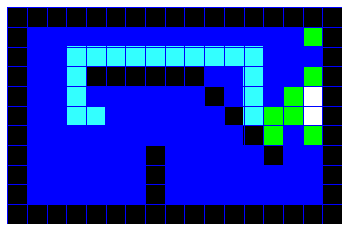

In [8]:
print("Discovered Path:\t", djik_path)
print("Path length:    \t", len(djik_path))
print("Processed Nodes:\t", djik_process_count)

for node in djik_path:
    djik_state[node] = PATH
showgrid(djik_state)

### bcd) A*

The following function takes the start and goal positions along with the state of the board and the path cost metric and goes through the A* algorithm. The function returns a tuple where the first index holds the computed path from the start to the goal and the second index holds the final state of the board.

The path cost is given as a function mapping a tuple to an integer. As such, an input `c_path(node)` should return the path cost for that node.

The A* algorithm works almost exactly like Djikstra, except it takes into account the cost of the current path when selecting a node from ondeck. The algorithm works as follows:
1. A list (ondeck) is created to hold ondeck nodes, and a dictionary (prior_node) is created to map a node to its prior node. The Queue is initialized holding only the start node, and the dictionary starts only mapping the start node to `None` (since start does not have a prior node)
2. While ondeck contains nodes:
    * Sort ondeck by increasing path cost, so the first node has the lowest path cost.
    * Pop the first node in ondeck, and call it the 'current' node. (This node will have the lowest path cost of all nodes in ondeck)
    * If the current node is the goal, mark it as processed and return the path and state.
    * For each node which can be reached from the current node, if its state is unknown, mark it as ondeck by adding it to the list and marking its state, then assign its prior node to the current node.
    * Once all child nodes have been checked, mark the current node as processed.
3. When ondeck is empty, this means a path could not be found, so return None for the path and the final state.

In [9]:
def astar(start, goal, state, c_path):
    # Tracks which nodes are in ondeck and when they were added to ondeck
    ondeck = [start]
    # For any node, stores the node prior to it
    prior_node = {start:None}
    
    # While there is a node that has not been fully processed, process it
    while ondeck:
        # Sort ondeck by the path cost for each node, so the first entry
        # has the lowest path cost, then get the first entry 
        ondeck.sort(key=c_path)
        current = ondeck.pop(0)
        
        if current == goal:
            state[current] = PROCESSED
            # Return the path used to get to the goal and the state
            return (build_path(goal, prior_node), state)
        
        # Get the next nodes in each direction (up down left right)
        for i in (-1,1): # -1 for up/left, +1 for down/right
            for axis in (0, 1): # axis 0 for right/left, 1 for up/down
                
                # Find the next node in the specified direction
                nnode = (current[0] + (i if axis==1 else 0),
                         current[1] + (i if axis==0 else 0))
                
                # If the node has not been seen yet, add to ondeck and track
                # the node used to get to this one (the current node)
                if state[nnode] == UNKNOWN:
                    state[nnode] = ONDECK
                    ondeck.append(nnode)
                    prior_node[nnode] = current
        
        # Mark the node as processed, check if we've reached the goal, then continue
        state[current] = PROCESSED
    
    # If a path could not be found
    return (None, state)

### b) Manhattan Dist. Cost to Go

In this case, the path cost of a node is the sum of the manhattan distance from that node to the start and the goal nodes. This is defined in a lambda function as:

In [10]:
c_path_1 = lambda x: 1*(abs(x[0]- GOAL[0]) + abs(x[1]- GOAL[1])) +\
                     1*(abs(x[0]-START[0]) + abs(x[1]-START[1]))

Running the A* algorithm with this path cost metric and printing results, we see:

Discovered Path:	 [(5, 4), (5, 3), (4, 3), (3, 3), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (3, 10), (3, 11), (4, 11), (4, 12), (5, 12)]
Path length:    	 17
Processed Nodes:	 63


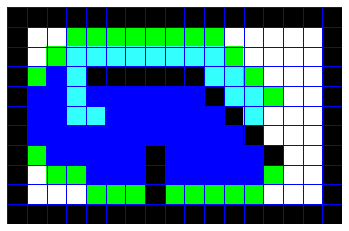

In [11]:
# Runs A*
(astar_path, astar_state) = astar(START, GOAL, resetState(), c_path_1)

# Counts the final number of processed nodes
astar_process_count = sum([x.tolist().count(PROCESSED) for x in astar_state])

print("Discovered Path:\t", astar_path)
print("Path length:    \t", len(astar_path))
print("Processed Nodes:\t", astar_process_count)

for node in astar_path:
    astar_state[node] = PATH
showgrid(astar_state)

### c) Double Manhattan Dist Cost to Go

Now, we redefine the cost to go by multiplying it by 2. As such, for the path cost we must multiply the manhattan distance to the goal by 2, while maintaining the cost from the start. The path cost is now defined as follows:

In [12]:
c_path_2 = lambda x: 2*(abs(x[0]- GOAL[0]) + abs(x[1]- GOAL[1])) +\
                     1*(abs(x[0]-START[0]) + abs(x[1]-START[1]))

Running A* as before and printing results, we have:

Discovered Path:	 [(5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (6, 10), (6, 11), (7, 11), (7, 12), (8, 12), (8, 13), (8, 14), (7, 14), (6, 14), (6, 13), (5, 13), (5, 12)]
Path length:    	 19
Processed Nodes:	 50


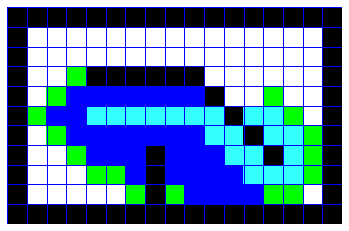

In [13]:
# Runs A*
(astar_path, astar_state) = astar(START, GOAL, resetState(), c_path_2)

# Counts the final number of processed nodes
astar_process_count = sum([x.tolist().count(PROCESSED) for x in astar_state])

print("Discovered Path:\t", astar_path)
print("Path length:    \t", len(astar_path))
print("Processed Nodes:\t", astar_process_count)

for node in astar_path:
    astar_state[node] = PATH
showgrid(astar_state)

### d) 10x Manhattan Dist Cost to Go

Now, we create a much more aggressive heuristic, multiplying the manhattan distance to the goal by 10. The new path cost is defined as follows:

In [14]:
c_path_10 = lambda x: 10*(abs(x[0]- GOAL[0]) + abs(x[1]- GOAL[1])) +\
                       1*(abs(x[0]-START[0]) + abs(x[1]-START[1]))

The results for A* with this path cost function are given below:

Discovered Path:	 [(5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (6, 10), (6, 11), (7, 11), (7, 12), (8, 12), (8, 13), (8, 14), (7, 14), (6, 14), (6, 13), (5, 13), (5, 12)]
Path length:    	 19
Processed Nodes:	 29


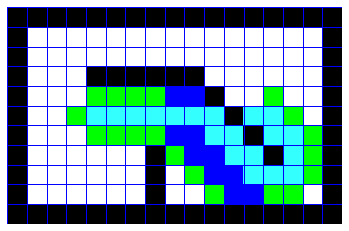

In [15]:
# Runs A*
(astar_path, astar_state) = astar(START, GOAL, resetState(), c_path_10)

# Counts the final number of processed nodes
astar_process_count = sum([x.tolist().count(PROCESSED) for x in astar_state])

print("Discovered Path:\t", astar_path)
print("Path length:    \t", len(astar_path))
print("Processed Nodes:\t", astar_process_count)

for node in astar_path:
    astar_state[node] = PATH
showgrid(astar_state)

### Overall

As shown above, the optimal path of length 17 was reached by both A* with the lightest weight and Djikstra, but A* took much less processing power, processing only 63 nodes compared to Djikstra's 113. On the other hand, the two heavier weighted A* runs both found slightly less optimal paths of length 19, but processed only 50 nodes in the 2x case and 29 in the 10x case. This shows A* drastically cuts down on processing time, but when the heuristic is not consistent there is no guarantee that the optimal state will be reached, while with Djikstra optimality is always guaranteed at the expense of processing power.

## Problem 2: Check Linux and ROS

I had a bunch of issues with VirtualBox last term, but I believe they have been resolved, since we discovered during the final few weeks that having VirtualBox in scaled mode made it very prone to lagging and glitching. I also now have a secondary Windows machine I will be able to work on if my Mac machine fails me again, so I'm all set with VirtualBox/Linux/ROS.

## Problem 3: Time Spent

**Total Time: 3 hr 10 min**
* Problem 1 Programming: 2 hours
* Problem 1 Writeup: 1 hour
* Linux/ROS: 10 min